In [1]:
versioninfo()

Julia Version 1.9.1
Commit 147bdf428cd (2023-06-07 08:27 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 16 × AMD Ryzen 7 PRO 4750U with Radeon Graphics
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver2)
  Threads: 2 on 16 virtual cores
Environment:
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [6]:
# Import all libraries.
using Turing, StatsPlots, Random, Distributions

In [7]:
using Fmt
print(Fmt.format(f"{1} {2}", "foo", "haha") )
println(Fmt.format(f"{1} {2}", "foo", "bar") )
println(Fmt.format(f"{x} {y}", x = "foo", y = "bar") )

foo hahafoo bar
foo bar


In [10]:
x = 42
print(f"x is {$x}.")
display(f"x is {$x}.")


x is 42.

"x is 42."

# 1. Turing.jl

- https://turinglang.org/
- https://github.com/TuringLang/Turing.jl


# 2. The Problem: Coin flipping

Flip a coin. A random variable x = 1 if the coin is head up. x=0 if the coin is tail up.

## 2.1 Question
- Input: a sequence of observed x.
- Output: what is the p(head up) of the coin?

## 2.2 Input: flip 100 times

The number of ups is 43/100.


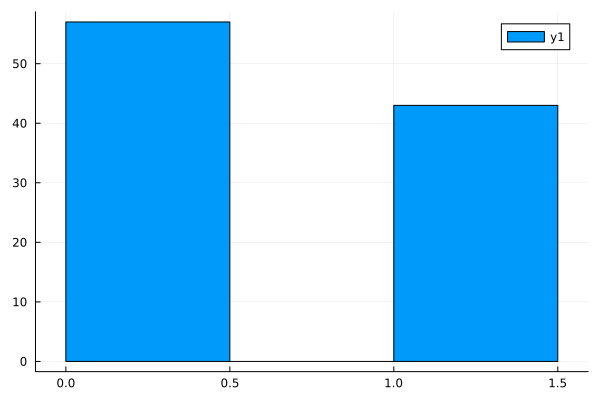

In [11]:
# Set the true probability of heads in a coin.
p_true = 0.5

# Iterate from having seen 0 observations to 100 observations.
Ns = 0:100

# Fix the seed and draw data from a Bernoulli distribution, i.e. draw heads or tails.
Random.seed!(12)
data = rand(Bernoulli(p_true), last(Ns))

println(Fmt.format(f"The number of ups is {1}/{2}.", sum(data), length(data)) ); 
histogram(data)

# 3 Frequentist/Likelihood approach

p is an unknown parameter to be solved.


$$ x_i \sim Bernoulli(p)$$


The MLE (maximum likelihood estimator) is $\hat p=\frac{\sum_{i=1}^{i=N} x_i }{N}$ and why?

- What is the difference between likelihood and probability? What is MLE?
- Why most estimators we know/use are MLE estimators?
- Analytic/closed-form （解析） solution vs Monte Carlo solution vs Brute force solution?
  - https://en.wikipedia.org/wiki/Closed-form_expression

For any model (Likelihood or Bayesian):
- Is there an analytic solution? No for most real-world problems.
- Is there a monte carlo solution? Yes for most real-world problems.
- Is there a brute-force solution? Yes. But may take hundreds of years.


## 3.1 The MLE (maximum likelihood estimator) is  $\hat p=\frac{\sum_{i=1}^{i=N} x_i }{N}$ and why?


- https://stats.stackexchange.com/questions/275380/maximum-likelihood-estimation-for-bernoulli-distribution

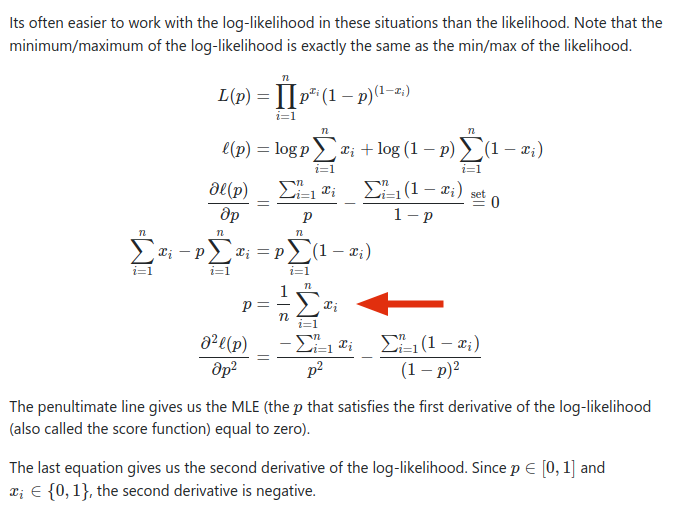

# 4 Bayesian

p is a random variable with a prior distribution.

$$ p \sim Beta(\alpha, \beta)$$
$$ x_i \sim Bernoulli(p)$$

Note: x is Bernoulli, 0 or 1, not Binomial.

Question: derive the posterior distribution of $p$, AKA (Also Known As), $Prob(p|x_1, ... x_N)$.

- Is there an analytic solution to this? Yes, Beta-Binomial.

  - https://en.wikipedia.org/wiki/Beta-binomial_distribution
  
  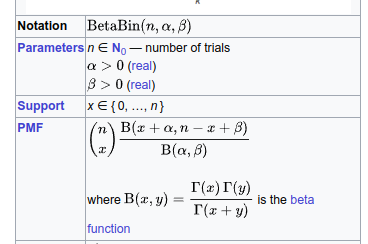

- Is there a monte carlo solution? Yes, we will talk about this today.

## 4.1 Declare our Bayesian model and Monte Carlo with a HMC sampler 

In [12]:
# Declare our Bayesian model，p ~ beta(1,1)， x ~ Bernoilli(p)
@model function coinflip(x)
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(1, 1)

    # The number of observations.
    N = length(x)
    for n in 1:N
        # Heads or tails of a coin are drawn from a Bernoulli distribution.
        x[n] ~ Bernoulli(p)
    end
end

coinflip (generic function with 2 methods)

  1.717038 seconds (1.85 M allocations: 122.273 MiB, 3.24% gc time, 98.40% compilation time)


Chains MCMC chain (1000×11×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.82 seconds
Compute duration  = 0.82 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           p    0.4309    0.0480    0.0009   3000.0000   616.3575    1.0011    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.3396    0.3976    0.4309    0.4633    0.5254


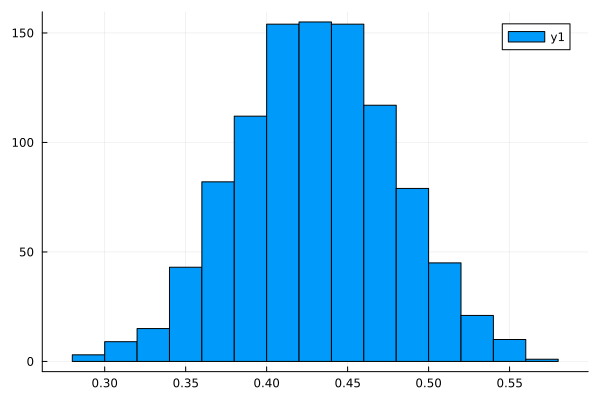

In [9]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 1000
ϵ = 0.05
τ = 10

# Start sampling.
@time chain = sample(coinflip(data), HMC(ϵ, τ), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

┌ Info: Found initial step size
└   ϵ = 0.6000000000000001
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.267643 seconds (2.43 M allocations: 172.154 MiB, 23.85% gc time)


Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.22 seconds
Compute duration  = 0.22 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           p    0.4314    0.0486    0.0007   5376.4118   6857.8386    1.0002   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.3354    0.3994    0.4311    0.4641    0.5272


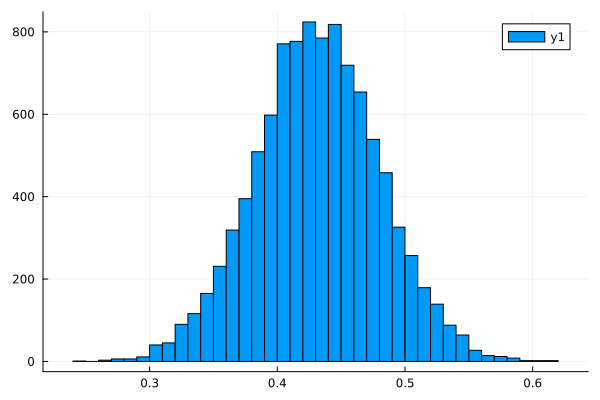

In [46]:
# Using NUTS as sampler
@time chain = sample(coinflip(data), NUTS(), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

### 4.1.1 The posterior of p is max at $ p=0.4311$, almost same as MLE. Not 0.5!
Because:
1) the data is 43% up;
2) we used a flat prior (uniform $\in [0,1]$). 

## 4.2 Input is 10X more data.

The number of ups is 493/1000.


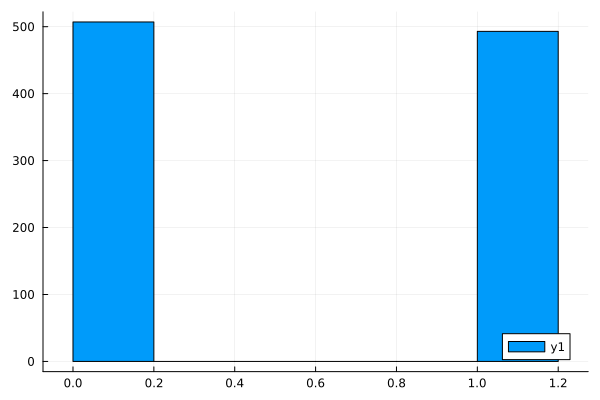

In [7]:
# Fix the seed and draw data from a Bernoulli distribution, i.e. draw heads or tails.
Random.seed!(7)
data2 = rand(Bernoulli(p_true), 1000)
println(Fmt.format(f"The number of ups is {1}/{2}.", sum(data2), length(data2)) ); 

histogram(data2)

### 4.2.1 sample using the same model but with 10X iterations

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.175580 seconds (2.50 M allocations: 140.212 MiB, 6.49% gc time)


Chains MCMC chain (10000×11×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 1.12 seconds
Compute duration  = 1.12 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk    ess_tail      rhat  ⋯
      Symbol   Float64   Float64   Float64      Float64     Float64   Float64  ⋯

           p    0.4932    0.0157    0.0001   14443.3380   9928.3113    0.9999  ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.4627    0.4825    0.4932    0.5039    0.5236


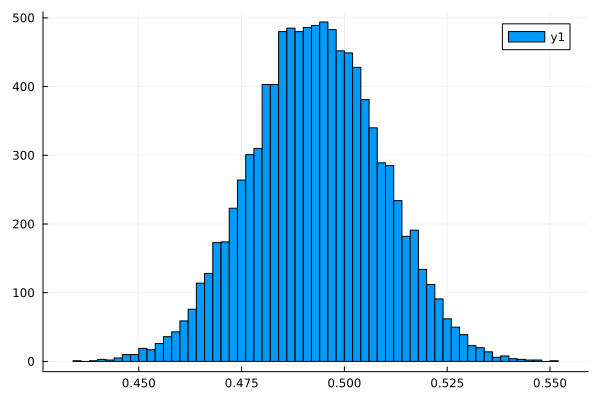

In [38]:
# sampling using the same model but with more iterations
iterations = 10000
ϵ = 0.05
τ = 10
# Start sampling.
@time chain = sample(coinflip(data2), HMC(ϵ, τ), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

### 4.2.2 same model, but using the NUTS sampler (default parameters)


┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.486774 seconds (2.44 M allocations: 172.963 MiB, 13.55% gc time)


Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.42 seconds
Compute duration  = 0.42 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           p    0.4934    0.0158    0.0002   5357.9946   7280.9086    0.9999   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.4630    0.4825    0.4933    0.5039    0.5246


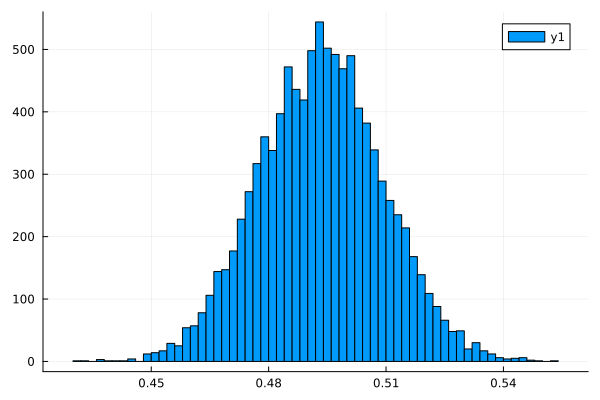

In [39]:
# Start sampling.
@time chain = sample(coinflip(data2), NUTS(), iterations)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

## 4.3 Modify the prior to alter the posterior

In [8]:
# Declare our Bayesian model，p ~ beta， x ~ Bernoilli(p)
# But let's modify the \alpha and \beta of the prior distribution.

@model function coinflip_prior_around_0_5(x)
    # Our prior belief about the probability of heads in a coin.
    p ~ Beta(100, 100)

    # The number of observations.
    N = length(x)
    for n in 1:N
        # Heads or tails of a coin are drawn from a Bernoulli distribution.
        x[n] ~ Bernoulli(p)
    end
end

coinflip_prior_around_0_5 (generic function with 2 methods)

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


 16.875248 seconds (33.22 M allocations: 2.109 GiB, 7.14% gc time, 98.08% compilation time: <1% of which was recompilation)


Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 7.52 seconds
Compute duration  = 7.52 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           p    0.4768    0.0291    0.0005   3733.2840   6724.6674    1.0008   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.4214    0.4565    0.4768    0.4964    0.5342


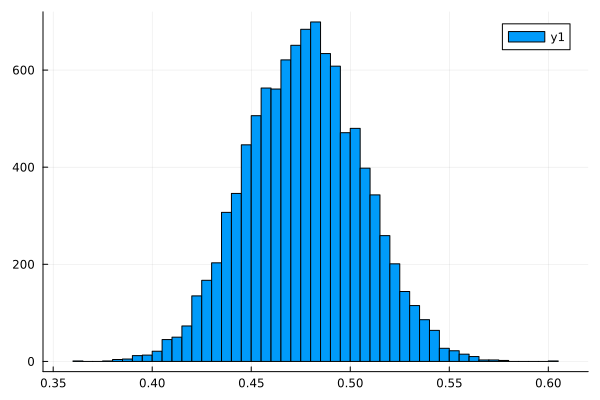

In [10]:
# Start sampling.
@time chain = sample(coinflip_prior_around_0_5(data), NUTS(), 10000)
display(chain)
# Plot a summary of the sampling process for the parameter p, i.e. the probability of heads in a coin.
histogram(chain[:p])

### 4.3.1 Conclusion
- With a Strong prior beta(100,100) around 0.5, we can obtain a posterior estimate around 0.48, instead of 0.43.

# 5 Homework
- Adjust the prior belief (up or down alpha & beta) in 3.3 and see how the posterior changes.

# 6 Next chapter

Three types of coins were minted by 秦朝造币厂:

1. Coin 1: 25% up.
2. Coin 2: 50% up.
3. Coin 3: 75% up.

Two kinds of problems.
1. Infer the true type of coin.
2. Predict the prob of head up of a new coin.

# 7 Test two different Negative Binomial models
1. with a beta prior for p and Uniform prior for r
1. with a beta prior for p and Gamma prior for r 

In [23]:
using Turing, Distributions

# Generate synthetic data with known parameters
Random.seed!(28)
n = 1000
r = 3
p = 0.2
y = rand(NegativeBinomial(r, p), n)

# Bayesian Negative binomial model
@model nb_bayes(y) = begin
    # Defining variables
    r ~ Uniform(0, 100)
    p ~ Beta(2, 2)
    
    # Likelihood function
    y_dist = NegativeBinomial(r, p)
    y ~ y_dist
end


# Define the negative binomial likelihood
@model function negative_binomial_model(y)
    # Prior distribution for the success probability
    p ~ Beta(1, 1)
    # Prior distribution for the dispersion parameter
    r ~ Gamma(1, 1)
    y_dist = NegativeBinomial(r, p)
    # Likelihood
    for i in eachindex(y)
        y[i] ~ y_dist
    end
end


negative_binomial_model (generic function with 2 methods)

In [24]:
y

1000-element Vector{Int64}:
 14
 23
 20
  6
 25
  3
 12
  5
  2
  7
 12
 26
  3
  ⋮
 10
  4
 14
  8
 12
 29
 12
 14
  6
  8
  8
  8

## 7.1 NB with a beta prior for p and Uniform prior for r

In [25]:
# Sampling from the posterior distribution
@time chain_w_uniform_and_beta_prior = sample(nb_bayes(y), NUTS(), 1000)
display(chain_w_uniform_and_beta_prior)

┌ Info: Found initial step size
└   ϵ = 0.0125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  2.922870 seconds (1.68 M allocations: 128.645 MiB, 2.79% gc time, 52.06% compilation time: 83% of which was recompilation)


Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.32 seconds
Compute duration  = 2.32 seconds
parameters        = r, p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           r    3.0407    0.1813    0.0148   170.7149   140.1706    1.0016     ⋯
           p    0.1992    0.0099    0.0007   226.5564   158.0827    1.0016     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           

In [26]:
# Summarizing posterior distribution
@time describe(chain_w_uniform_and_beta_prior)

  0.001420 seconds (864 allocations: 908.953 KiB)


2-element Vector{ChainDataFrame}:
 Summary Statistics (2 x 8)
 Quantiles (2 x 6)

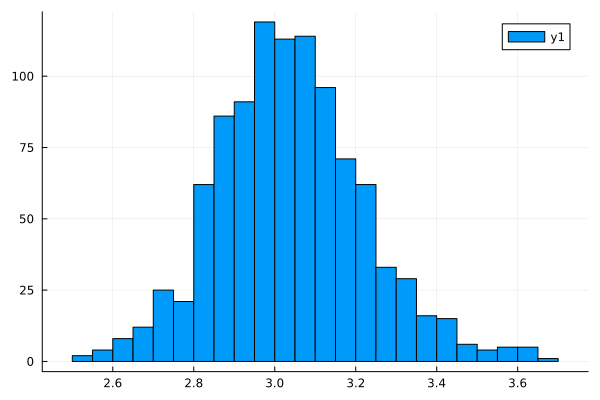

In [27]:
histogram(chain_w_uniform_and_beta_prior[:r])

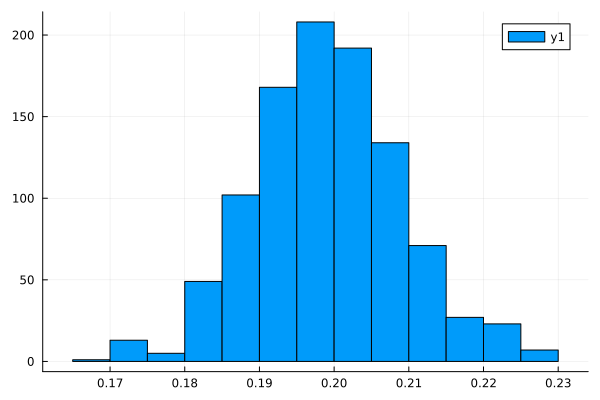

In [28]:
histogram(chain_w_uniform_and_beta_prior[:p])

## 7.2 NB with a beta prior for p and Gamma prior for r

In [29]:
@time chain_with_gamma_and_beta_prior = sample(negative_binomial_model(y), NUTS(0.65), 1000)

┌ Info: Found initial step size
└   ϵ = 0.025
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  2.946918 seconds (1.68 M allocations: 129.877 MiB, 1.48% gc time, 52.29% compilation time: 83% of which was recompilation)


Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.37 seconds
Compute duration  = 2.37 seconds
parameters        = p, r
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

           p    0.1970    0.0086    0.0005   258.3806   320.8002    1.0027     ⋯
           r    3.0005    0.1551    0.0098   248.9200   298.4528    1.0050     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           

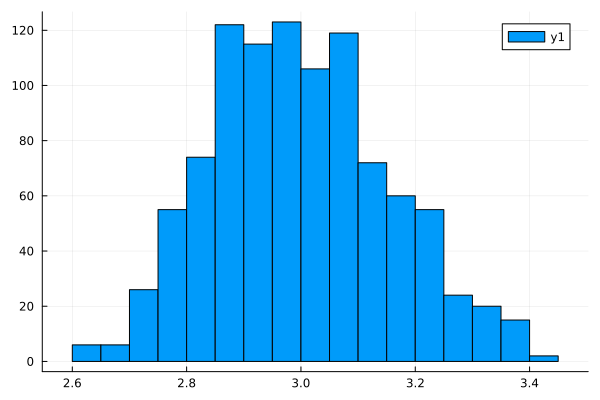

In [30]:
histogram(chain_with_gamma_and_beta_prior[:r])

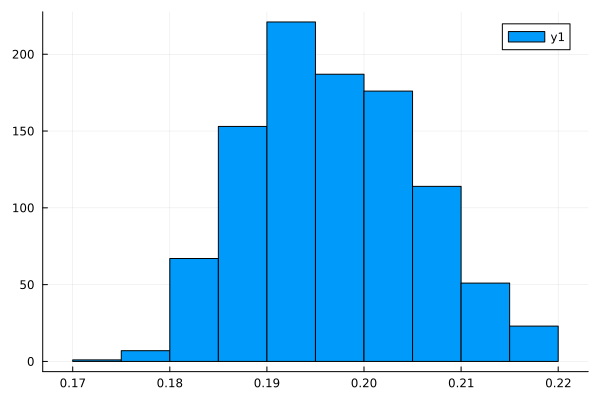

In [31]:
histogram(chain_with_gamma_and_beta_prior[:p])

# 8 Estimate p of Binomial(N, p) from Binomial data with different Ns

In [131]:
function simulate_data(p::Float64, cov_mean::Int=4000, cov_std::Int=700, no_of_samples::Int=500)
    # Generate synthetic data with known parameters
    # cov_mean, cov_std are the parameters for the normal distribution.
    
    # fix the seed
    Random.seed!(10)
    # Create a normal distribution centered around 4000
    cov_dist = Normal(cov_mean, cov_std)

    # Sample an integer coverage vector from the distribution
    N_v = round.(rand(cov_dist, no_of_samples))

    x_v = zeros(Int, length(N_v))
    for (i, N) in enumerate(N_v)
        x_v[i] = rand(Binomial(N, p) )
    end
    vaf_v = x_v./N_v
    return N_v, x_v, vaf_v
end

@time N_v, x_v, vaf_v = simulate_data(0.0005)
@time N_v_005, x_v_005, vaf_v_005 = simulate_data(0.005)
@time N_v_00001, x_v_00001, vaf_v_00001 = simulate_data(0.00001)

@time println("The number of samples with VAF=0: ", sum(vaf_v_00001.==0) )

  0.000169 seconds (10 allocations: 16.703 KiB)
  0.000137 seconds (10 allocations: 16.703 KiB)
  0.000099 seconds (10 allocations: 16.703 KiB)
The number of samples with VAF=0: 490
  0.000388 seconds (163 allocations: 16.188 KiB)


In [136]:
typeof(vaf_v)

Vector{Float64} (alias for Array{Float64, 1})

In [140]:
function plot_histogram(N_v::Vector{Float64}, x_v::Vector{Int64}, vaf_v::Vector{Float64}, p::Float64)
    @time h1 = histogram(N_v, title="Histogram of N", xaxis="N")
    @time h2 = histogram(x_v, title="Histogram of x", xaxis="x")
    @time h_of_vaf_v = histogram(vaf_v, xaxis="VAF", bins=30, legend=false)
    @time plot(h1, h2, h_of_vaf_v, layout=(2,2), left_margin=5*Plots.mm, bottom_margin=5*Plots.mm, size=(1000,830) ) 
end


plot_histogram (generic function with 1 method)

  0.002611 seconds (8.39 k allocations: 296.875 KiB)
  0.002208 seconds (8.31 k allocations: 294.719 KiB)
  0.001452 seconds (8.54 k allocations: 302.734 KiB)
  0.001734 seconds (4.87 k allocations: 349.516 KiB)


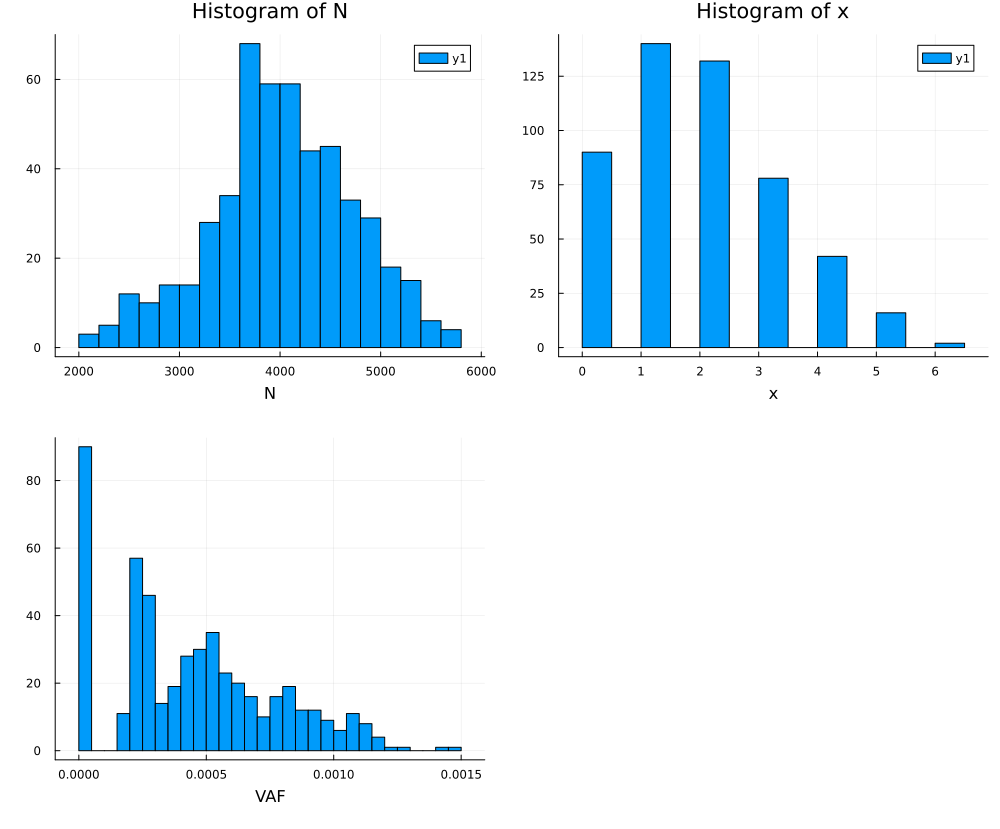

In [141]:
plot_histogram(N_v, x_v, vaf_v, 0.0005)

  0.003142 seconds (8.39 k allocations: 296.875 KiB)
  0.002698 seconds (8.35 k allocations: 295.859 KiB)
  0.003489 seconds (8.58 k allocations: 303.891 KiB)
  0.001732 seconds (4.87 k allocations: 350.266 KiB)


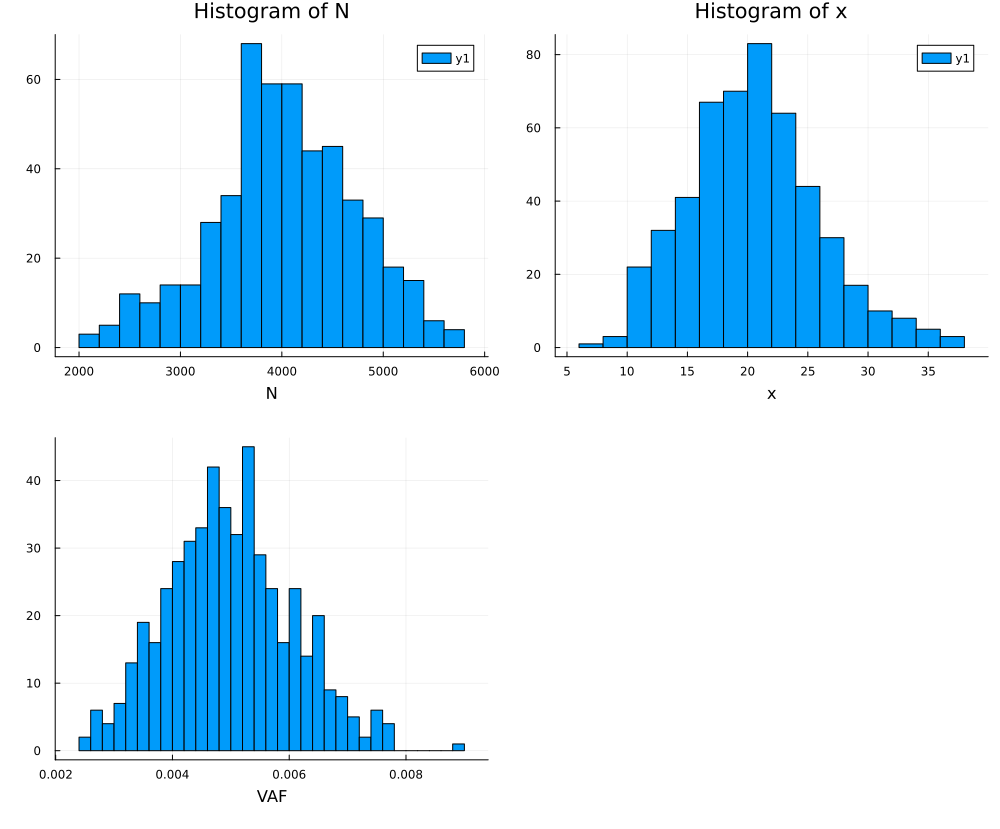

In [142]:
plot_histogram(N_v_005, x_v_005, vaf_v_005, 0.005)

  0.005512 seconds (8.39 k allocations: 296.875 KiB)
  0.004142 seconds (8.18 k allocations: 288.219 KiB)
  0.003179 seconds (8.38 k allocations: 287.172 KiB)
  0.002986 seconds (4.87 k allocations: 347.125 KiB)


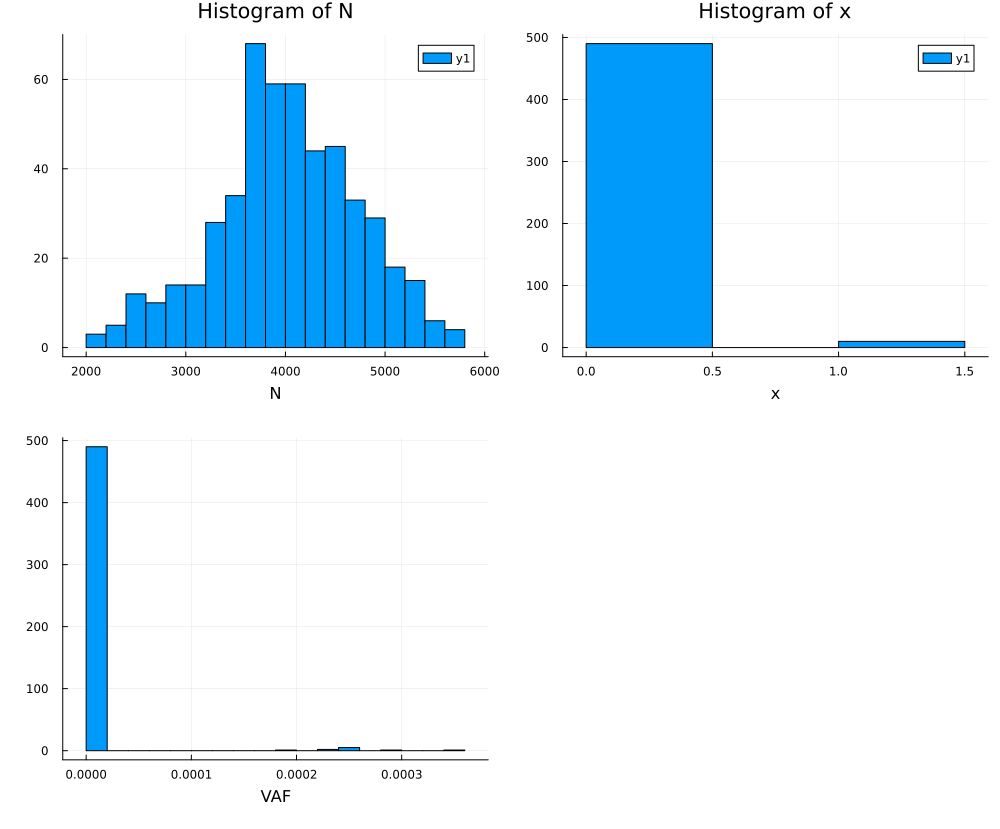

In [143]:
plot_histogram(N_v_00001, x_v_00001, vaf_v_00001, 0.00001)

In [90]:
# Define the model
@model binomial_w_beta_prior(N, x) = begin
    # Prior distribution for the success probability
    p ~ Beta(1, 5)
    # Prior distribution for the dispersion parameter, for the NB distribution
    # r ~ Gamma(1, 1)
    #y_dist = NegativeBinomial(r, p)
    # Likelihood
    for i in eachindex(N)
        x[i] ~ Binomial(N[i], p)
    end
end

binomial_w_beta_prior (generic function with 2 methods)

## 8.1 Estimate if true p is 0.0005

In [91]:
# Sampling from the posterior distribution
@time chain_binomial_w_beta_prior = sample(binomial_w_beta_prior(N_v, x_v), NUTS(), 2000)
display(chain_binomial_w_beta_prior)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.928267 seconds (1.52 M allocations: 109.075 MiB, 3.73% gc time, 73.85% compilation time: 81% of which was recompilation)


Chains MCMC chain (2000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 1.31 seconds
Compute duration  = 1.31 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk    ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64    Float64     Float64   Float64    ⋯

           p    0.0004    0.0000    0.0000   936.1444   1516.4132    1.0013    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.0004    0.0004    0.0004    0.0005    0.0005


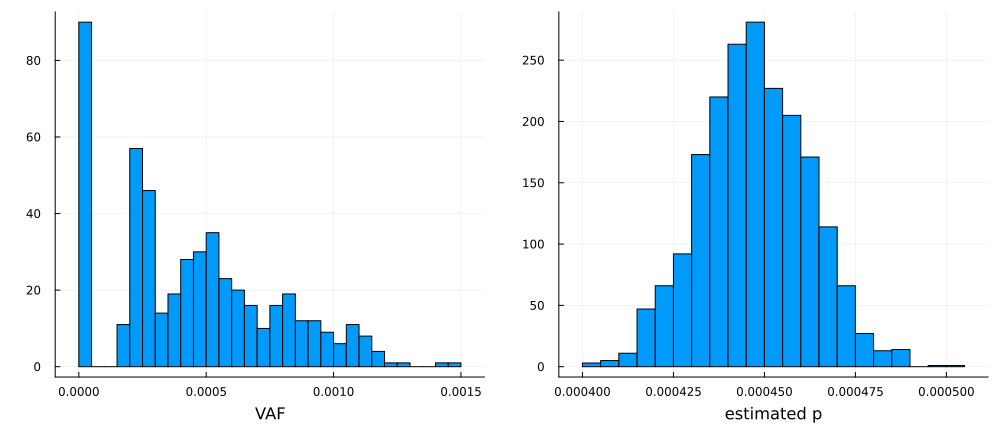

In [145]:
function plot_estimates(vaf_v, estimated_p)
    h_of_vaf_v = histogram(vaf_v, xaxis="VAF", bins=30, legend=false)
    h_of_p_bin = histogram(estimated_p, xaxis="estimated p", legend=false)
    plot(h_of_vaf_v, h_of_p_bin, layout=(1,2), left_margin=5*Plots.mm, bottom_margin=5*Plots.mm, size=(1000,430) )
end
plot_estimates(vaf_v, chain_binomial_w_beta_prior[:p])

## 8.2 Estimate if true p is 0.005

In [129]:
# Sampling from the posterior distribution
@time chain_binomial_w_beta_prior_005 = sample(binomial_w_beta_prior(N_v_005, x_v_005), NUTS(), 2000)
display(chain_binomial_w_beta_prior_005)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.232931 seconds (671.45 k allocations: 49.092 MiB, 4.78% gc time)


Chains MCMC chain (2000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 1.19 seconds
Compute duration  = 1.19 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk    ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64    Float64     Float64   Float64    ⋯

           p    0.0050    0.0000    0.0000   774.5739   1078.2509    1.0006    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.0049    0.0049    0.0050    0.0050    0.0051


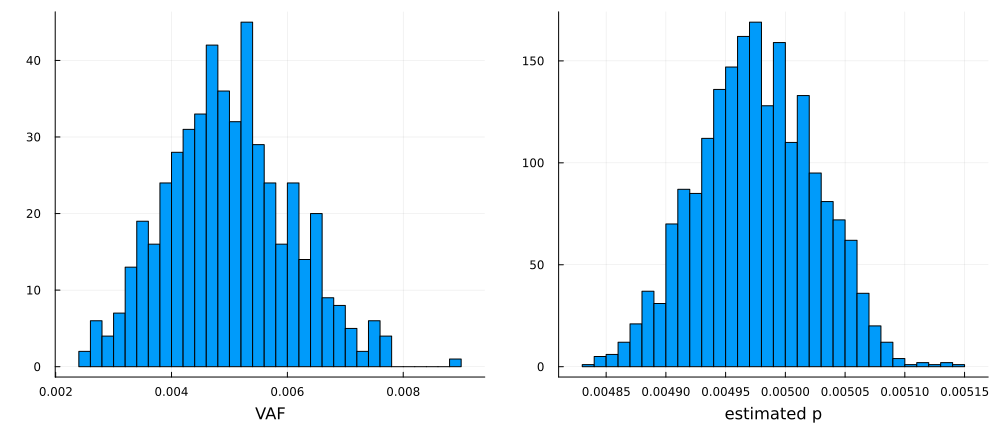

In [146]:
plot_estimates(vaf_v_005, chain_binomial_w_beta_prior_005[:p])

## 8.3 Estmate if true p is 0.00001

In [144]:
# Sampling from the posterior distribution
@time chain_binomial_w_beta_prior_00001 = sample(binomial_w_beta_prior(N_v_00001, x_v_00001), NUTS(), 2000)
display(chain_binomial_w_beta_prior_00001)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.764023 seconds (654.45 k allocations: 47.956 MiB, 6.60% gc time)


Chains MCMC chain (2000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 0.75 seconds
Compute duration  = 0.75 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           p    0.0000    0.0000    0.0000   1149.2996   1528.9093    0.9997   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.0000    0.0000    0.0000    0.0000    0.0000


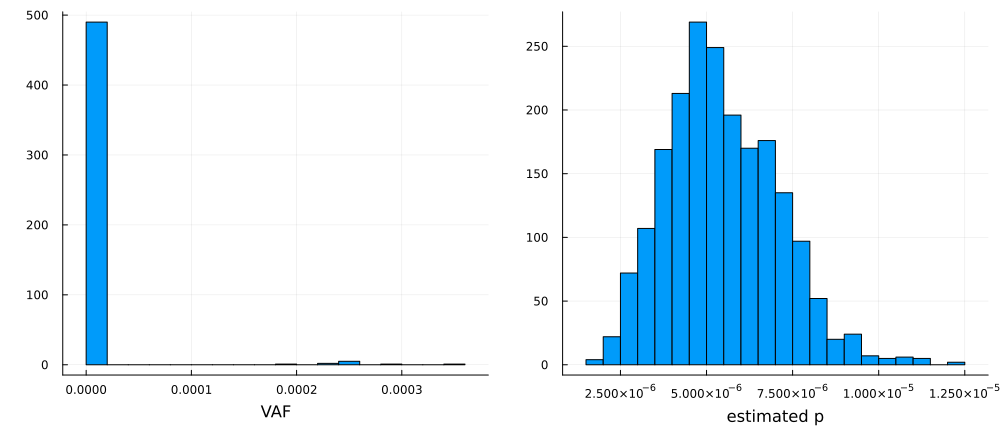

In [147]:
plot_estimates(vaf_v_00001, chain_binomial_w_beta_prior_00001[:p])

# 9 Estimate p of NegativeBinomial(r, p) from Binomial data with different Ns

In [ ]:
no_of_failures_v = N.

500-element Vector{Float64}:
 4892.0
 3421.0
 4646.0
 4373.0
 4073.0
 3849.0
 3049.0
 4216.0
 3476.0
 5058.0
 4765.0
 4125.0
 3797.0
    ⋮
 4793.0
 4834.0
 3364.0
 3974.0
 4114.0
 2768.0
 3459.0
 4540.0
 4853.0
 3383.0
 3359.0
 3794.0

In [101]:
# Define the model
@model negbin_w_beta_prior(N, x) = begin
    # Prior distribution for the success probability
    p ~ Beta(1, 5)
    # Prior distribution for the dispersion parameter, for the NB distribution
    # r ~ Gamma(1, 1)
    #y_dist = NegativeBinomial(r, p)
    # Likelihood
    for i in eachindex(N)
        x[i] ~ NegativeBinomial(N[i]-x[i], p)
    end
end

negbin_w_beta_prior (generic function with 2 methods)

In [102]:
# Sampling from the posterior distribution
@time chain_negbin_w_beta_prior = sample(negbin_w_beta_prior(N_v, x_v), NUTS(), 2000)
display(chain_negbin_w_beta_prior)

┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


  1.953443 seconds (1.54 M allocations: 110.755 MiB, 4.19% gc time, 75.18% compilation time: 82% of which was recompilation)


Chains MCMC chain (2000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 1.32 seconds
Compute duration  = 1.32 seconds
parameters        = p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk    ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64    Float64     Float64   Float64    ⋯

           p    0.9995    0.0000    0.0000   935.5821   1314.4736    0.9995    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           p    0.9995    0.9995    0.9995    0.9996    0.9996


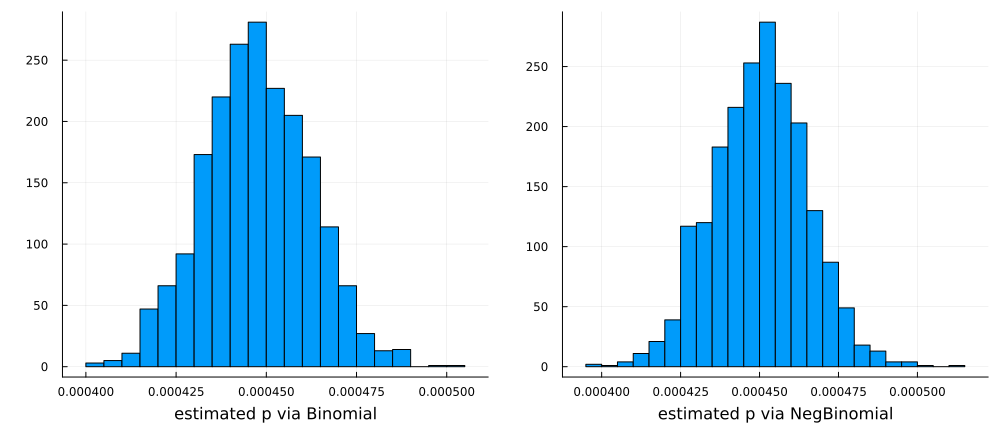

In [117]:
h_of_p_bin = histogram(chain_binomial_w_beta_prior[:p], xaxis="estimated p via Binomial", legend=false)
h_of_p_negbin = histogram(-(chain_negbin_w_beta_prior[:p].-1), xaxis="estimated p via NegBinomial", legend=false)
plot(h_of_p_bin, h_of_p_negbin, layout=(1,2), left_margin=5*Plots.mm, bottom_margin=5*Plots.mm, size=(1000,430) ) 

In [115]:
display(median(chain_binomial_w_beta_prior[:p]))
display(median(-(chain_negbin_w_beta_prior[:p].-1)))

0.0004470325598966233

0.0004505182409195174